In [103]:
! git clone https://github.com/MihiruthS/EN3160---Image-Processing-and-Machine-Vision

fatal: destination path 'EN3160---Image-Processing-and-Machine-Vision' already exists and is not an empty directory.


In [104]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

%matplotlib inline

# Question 01

In [105]:
def laplace_of_gaussian(sigma):
    # Calculate kernel half-width
    hw = int(3 * sigma)

    # Create 2D coordinate grid
    x = np.arange(-hw, hw + 1)
    X, Y = np.meshgrid(x, x)

    # Precompute common terms for clarity
    norm_factor = 1 / (np.pi * sigma**4)
    exp_term = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    scale_term = (X**2 + Y**2) / (2 * sigma**2) - 1

    # Calculate Laplacian of Gaussian
    log = norm_factor * scale_term * exp_term

    return log

In [106]:
def detect_max(img_log, sigma):
    coordinates = set()
    k = 1  # Radius for neighborhood
    threshold = 0.09

    # Get the dimensions of the image
    h, w = img_log.shape

    # Iterate over the valid region to avoid boundary issues
    for i in range(k, h - k):
        for j in range(k, w - k):
            # Extract the local neighborhood
            patch = img_log[i - k:i + k + 1, j - k:j + k + 1]

            # Check if the max value meets the threshold
            if patch.max() >= threshold:
                # Get the coordinates of the max value within the patch
                x, y = np.unravel_index(np.argmax(patch), patch.shape)
                # Adjust to the image's coordinate space and store the result
                coordinates.add((i + x - k, j + y - k))

    return coordinates

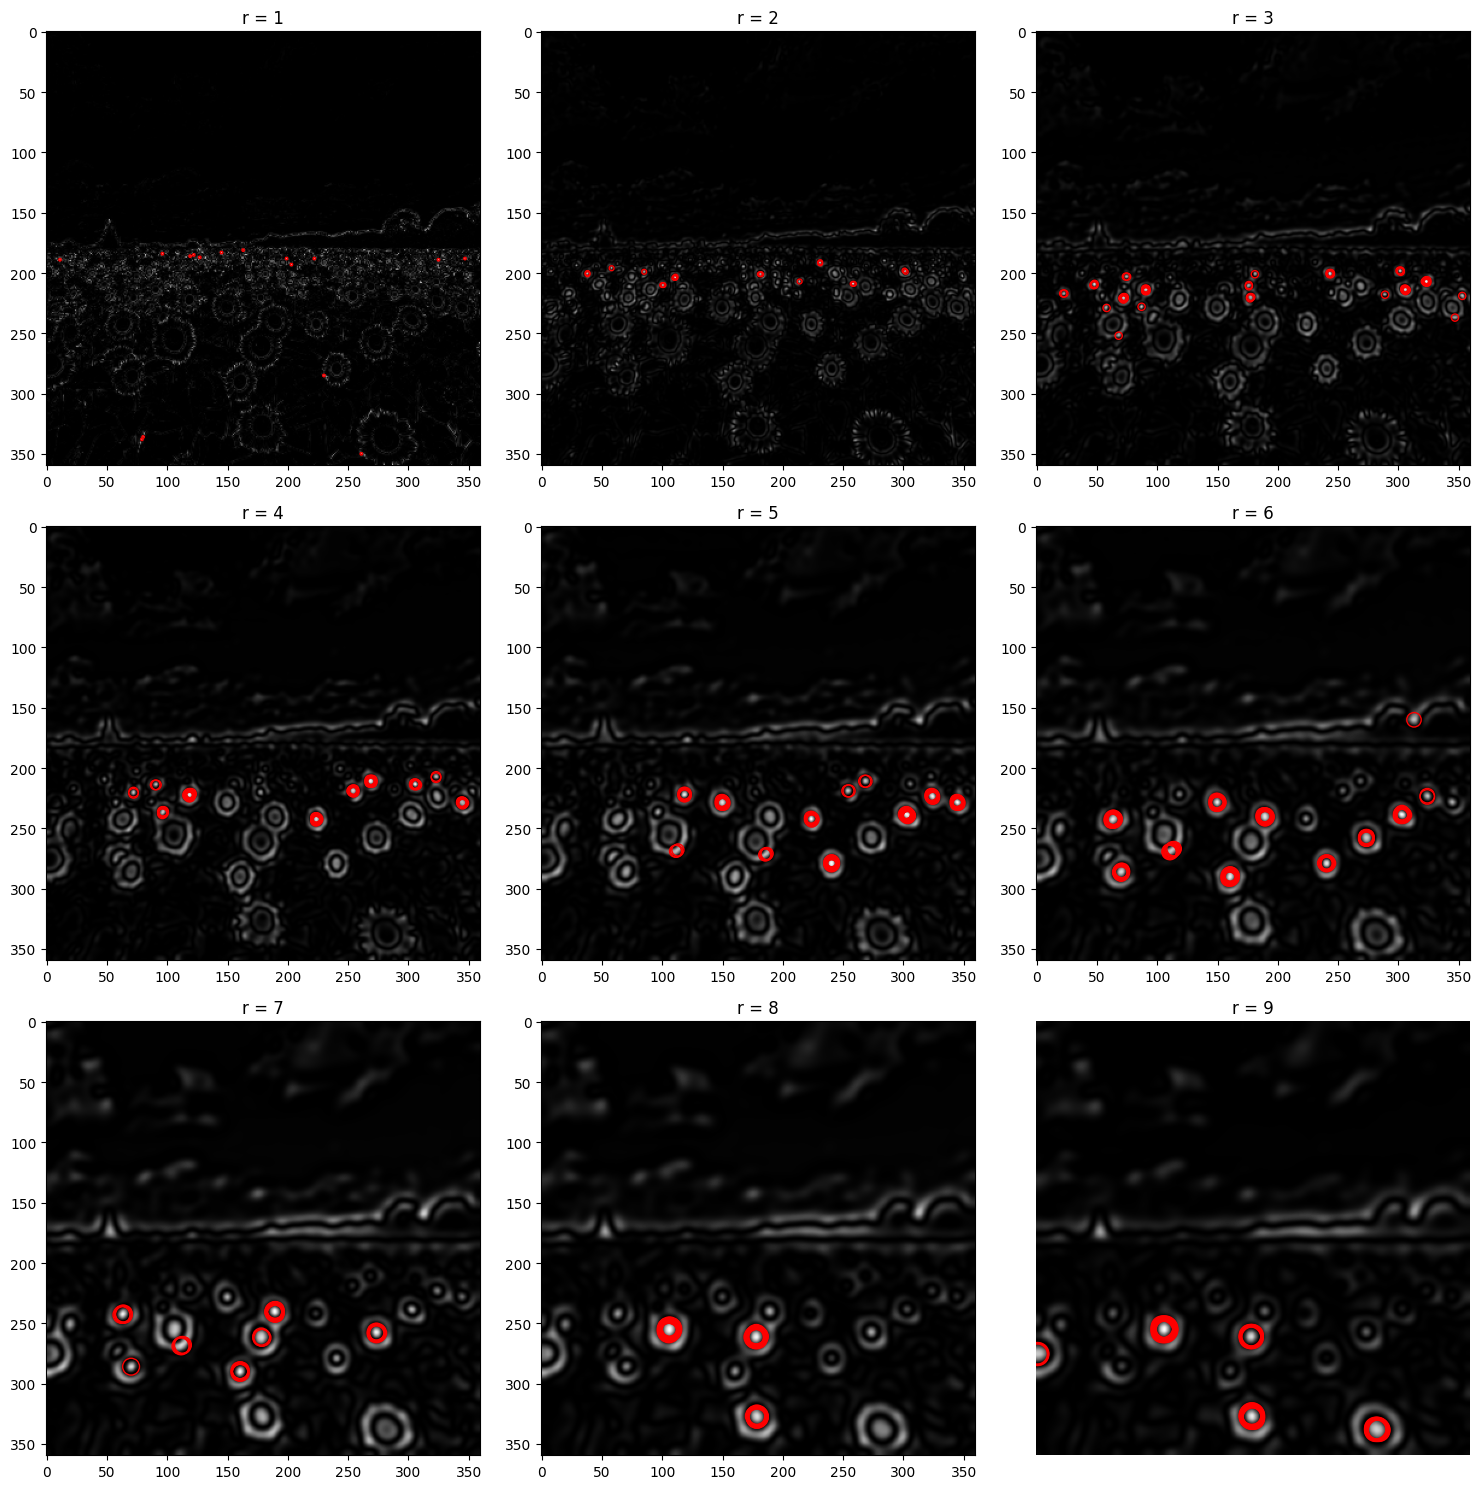

In [107]:
# Load and preprocess the image
img1 = cv.imread("/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255.0

# Create a 3x3 plot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over each subplot to apply LoG filtering and detect local peaks
for r, ax in enumerate(axes.flatten(), start=1):
    sigma = r / 1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)  # Compute the LoG kernel

    # Apply LoG filter and square the result
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    # Detect local peaks
    coordinates = detect_max(img1_log, sigma)

    # Display the LoG-filtered image
    ax.imshow(img1_log, cmap='gray')
    ax.set_title(f'r = {r}')

    # Draw circles around detected peaks
    for x, y in coordinates:
        circle = plt.Circle((y, x), sigma * 1.414, color='red', linewidth=1, fill=False)
        ax.add_patch(circle)

# Adjust layout and remove axis ticks for a cleaner look
plt.tight_layout()
plt.axis('off')
plt.show()

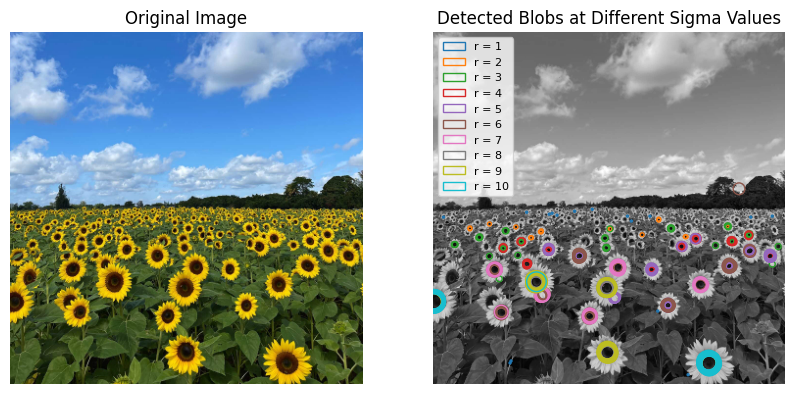

In [108]:
# Load the image and convert to grayscale
img1 = cv.imread('/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY).astype(np.float32) / 255.0

# Set up the plotting canvas
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Display original image
axes[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display grayscale image with detected blobs
ax = axes[1]
ax.imshow(img1_gray, cmap='gray')
ax.grid(False)
colors = list(mcolors.TABLEAU_COLORS.values())  # Use color values directly

# Initialize variables to store legend details
patches, labels = [], []

# Loop through different sigma values to detect blobs
for r in range(1, 11):
    sigma = r / 1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)  # Create LoG kernel
    img1_log = np.square(cv.filter2D(img1_gray, -1, LOG))  # Apply LoG filter

    coordinates = detect_max(img1_log, sigma)  # Detect local maxima

    # Plot detected blobs as circles
    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color=colors[r-1], linewidth=1, fill=False)
        ax.add_patch(c)

    # Store patch and label for legend
    patches.append(c)
    labels.append(f'r = {r}')

# Final plot adjustments
ax.set_xlim(0, img1.shape[1])
ax.set_title("Detected Blobs at Different Sigma Values")
ax.legend(patches, labels, loc='best', fontsize=8)
plt.axis('off')

plt.show()

# Question 02

In [109]:
! pip install tikzplotlib

<Axes: >

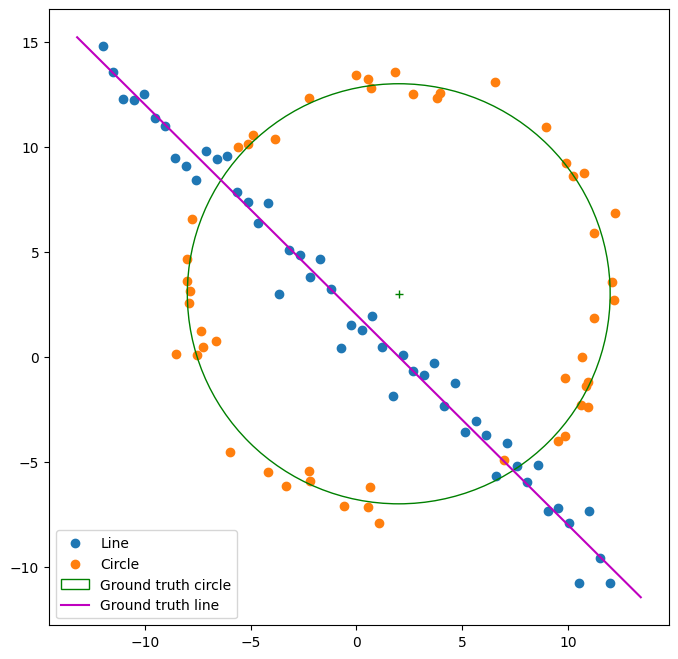

In [110]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center

s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

# Plotting
def plot_all(separate = True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()

In [111]:
def dist(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def line_eq(p1, p2):
    """Return the normalized line equation coefficients for the line through p1 and p2."""
    (x1, y1), (x2, y2) = p1, p2
    a, b = y2 - y1, -(x2 - x1)
    d = a * x1 + b * y1

    # Verify that the second point lies on the line defined by the first
    assert abs(a * x2 + b * y2 - d) < 1e-8

    # Normalize the coefficients
    norm = (a**2 + b**2)**0.5
    return a / norm, b / norm, d / norm

def circle_eq(p1, p2, p3):
    """Calculate the circumcenter and radius of the circle through three points."""
    (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3

    # Midpoints of line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x1 + x3) / 2, (y1 + y3) / 2

    # Slopes of the perpendicular bisectors
    s1 = -(x2 - x1) / (y2 - y1)
    s2 = -(x3 - x1) / (y3 - y1)

    # Intercepts of the bisectors
    c1, c2 = my1 - s1 * mx1, my2 - s2 * mx2

    # Calculate circumcenter (cx, cy)
    cx = (c2 - c1) / (s1 - s2)
    cy = s1 * cx + c1

    # Verify the circumcenter's consistency with the third point
    assert abs(s2 * cx + c2 - cy) < 1e-8

    # Calculate radius
    r = dist((cx, cy), p1)
    assert abs(dist((cx, cy), p2) - r) < 1e-8
    return cx, cy, r


In [112]:
# Squared error calculation for line and circle
def tls_error_line(params, *args):
    """Calculate the total least squares error for a line."""
    a, b, d = params
    indices, X = args
    errors = a * X[indices, 0] + b * X[indices, 1] - d
    return np.sum(errors**2)

def tls_error_circle(params, *args):
    """Calculate the total least squares error for a circle."""
    cx, cy, r = params
    indices, X = args
    distances = dist((cx, cy), (X[indices, 0], X[indices, 1]))
    return np.sum((distances - r)**2)


In [113]:
def consensus_line(params, threshold, X):
    """Determine inliers for a line based on the specified threshold."""
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < threshold)

def consensus_circle(params, threshold, X):
    """Determine inliers for a circle based on the specified threshold."""
    cx, cy, r = params
    errors = np.abs(dist((cx, cy), (X[:, 0], X[:, 1])) - r)  # Radial error
    return np.where(errors < threshold)

def constraint(params):
    """Constraint that ensures the line coefficients are normalized."""
    a, b, d = params
    return np.sqrt(a**2 + b**2) - 1

constraint_dict = {'type': 'eq', 'fun': constraint}

def least_squares_line_fit(indices, initial, X):
    """Perform least squares line fitting using SciPy's minimize."""
    res = minimize(fun=tls_error_line, x0=initial, args=(indices, X),
                   constraints=constraint_dict, tol=1e-6)
    print(res.x, res.fun)
    return res

def least_squares_circ_fit(indices, initial, X):
    """Perform least squares circle fitting using SciPy's minimize."""
    res = minimize(fun=tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(res.x, res.fun)
    return res


In [114]:
# Fitting the line

# Constants and initializations
iterations = 100
min_inlier_points = 2
num_points = X.shape[0]
np.random.seed(14)

error_threshold = 1.0  # Error threshold for selecting inliers
min_inliers_required = 0.4 * num_points  # Minimum inlier count for a good fit

# Variables to store the best fitting line details
best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_sample_points = None

# Iterative fitting process
for i in range(iterations):
    # Randomly select points to fit the line
    indices = np.random.choice(np.arange(num_points), size=min_inlier_points, replace=False)
    params = line_eq(X[indices[0]], X[indices[1]])

    # Determine inliers based on the consensus function
    inliers = consensus_line(params, error_threshold, X)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    # Recompute if the number of inliers meets the requirement
    if len(inliers) >= min_inliers_required:
        res = least_squares_line_fit(inliers, params, X)

        # Update the best model if the error is lower
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

# Final consensus for the best fitting line
final_line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]

# Output the best fitting line and its properties
print(f'Best line = {best_fitted_line}, No. of inliers = {len(final_line_inliers)}, best_error = {best_error}')


Iteration 0: No. of inliers = 11
Iteration 1: No. of inliers = 33
Iteration 2: No. of inliers = 11
Iteration 3: No. of inliers = 16
Iteration 4: No. of inliers = 13
Iteration 5: No. of inliers = 10
Iteration 6: No. of inliers = 8
Iteration 7: No. of inliers = 9
Iteration 8: No. of inliers = 11
Iteration 9: No. of inliers = 42
[0.70934293 0.70486354 1.41587257] 7.623886796570311
Iteration 10: No. of inliers = 6
Iteration 11: No. of inliers = 10
Iteration 12: No. of inliers = 6
Iteration 13: No. of inliers = 5
Iteration 14: No. of inliers = 7
Iteration 15: No. of inliers = 8
Iteration 16: No. of inliers = 8
Iteration 17: No. of inliers = 10
Iteration 18: No. of inliers = 10
Iteration 19: No. of inliers = 41
[0.71125634 0.70293273 1.32973587] 8.09300379429743
Iteration 20: No. of inliers = 8
Iteration 21: No. of inliers = 16
Iteration 22: No. of inliers = 30
Iteration 23: No. of inliers = 14
Iteration 24: No. of inliers = 21
Iteration 25: No. of inliers = 11
Iteration 26: No. of inliers =

In [115]:
# Fitting the circle

# Identifying remaining points that are not in line inliers
remaining_points = np.array([i for i in range(N) if i not in final_line_inliers])
X_rem = X[remaining_points]

# Constants and initializations for circle fitting
iterations = 100
min_inlier_points = 3  # Minimum points required to estimate a circle

error_threshold = 1.2   # Error threshold for selecting inliers
min_inliers_required = 0.4 * N  # Minimum inlier count for a good fit

# Variables to store the best fitting circle details
best_model_circle = None
best_fitted_circle = None
best_error = np.inf
best_circ_inliers = None
best_circ_sample_points = None

# Iterative fitting process
for i in range(iterations):
    # Randomly select points to fit the circle
    indices = np.random.choice(np.arange(len(X_rem)), size=min_inlier_points, replace=False)
    params = circle_eq(*X_rem[indices])

    # Determine inliers based on the consensus function
    inliers = consensus_circle(params, error_threshold, X_rem)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    # Recompute if the number of inliers meets the requirement
    if len(inliers) >= min_inliers_required:
        res = least_squares_circ_fit(inliers, params, X_rem)

        # Update the best model if the error is lower
        if res.fun < best_error:
            best_error = res.fun
            best_model_circle = params
            best_fitted_circle = res.x
            best_circ_inliers = inliers
            best_circ_sample_points = indices

# Final consensus for the best fitting circle
circ_inliers = consensus_circle(best_fitted_circle, error_threshold, X_rem)[0]

# Output the best fitting circle and its properties
print(f'Best circle = {best_fitted_circle}, No. of inliers = {len(circ_inliers)}, best_error = {best_error}')


Iteration 0: No. of inliers = 41
[ 2.17222438  3.11363938 10.18317164] 7.534245521663157
Iteration 1: No. of inliers = 16
Iteration 2: No. of inliers = 13
Iteration 3: No. of inliers = 20
Iteration 4: No. of inliers = 39
Iteration 5: No. of inliers = 20
Iteration 6: No. of inliers = 16
Iteration 7: No. of inliers = 35
Iteration 8: No. of inliers = 37
Iteration 9: No. of inliers = 13
Iteration 10: No. of inliers = 48
[ 2.02276752  3.01391358 10.09792279] 11.769876933419503
Iteration 11: No. of inliers = 7
Iteration 12: No. of inliers = 16
Iteration 13: No. of inliers = 28
Iteration 14: No. of inliers = 7
Iteration 15: No. of inliers = 18
Iteration 16: No. of inliers = 16
Iteration 17: No. of inliers = 40
[1.99485851 3.35950012 9.89093861] 8.561114673620839
Iteration 18: No. of inliers = 4
Iteration 19: No. of inliers = 28
Iteration 20: No. of inliers = 30
Iteration 21: No. of inliers = 24
Iteration 22: No. of inliers = 22
Iteration 23: No. of inliers = 6
Iteration 24: No. of inliers = 4

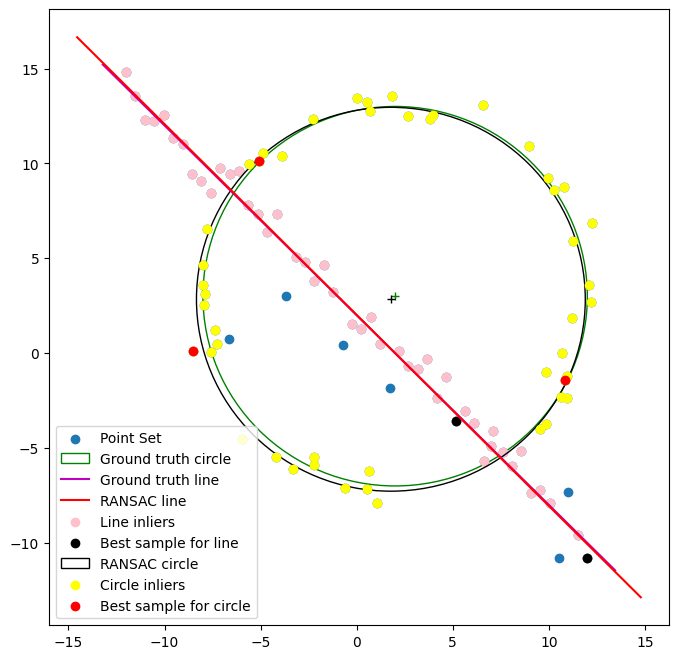

In [116]:
ax = plot_all(False)

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
A, B, D = best_fitted_line
indices = final_line_inliers

y_ = (D - A*x_) / B
plt.plot(x_, y_, color='r', label='RANSAC line')
ax.scatter(X[indices, 0], X[indices, 1], color = 'pink', label = "Line inliers")
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], color = 'black', label = "Best sample for line")

x0, y0, r0 = best_fitted_circle
circle_gt = plt.Circle((x0, y0), r0, color='black', fill=False, label='RANSAC circle')
ax.add_patch(circle_gt)
ax.plot(x0, y0, '+', color='black')

ax.scatter(X_rem[circ_inliers, 0], X_rem[circ_inliers, 1], color = 'yellow', label = "Circle inliers")
ax.scatter(X_rem[best_circ_sample_points, 0], X_rem[best_circ_sample_points, 1], color = 'red', label = "Best sample for circle")

plt.legend()

# Question 03

In [117]:
def superimpose(image, logo, dst_points, beta=0.3, alpha=1):
    # Get logo dimensions
    logo_height, logo_width, _ = logo.shape
    # Define source points for the logo's corners
    src_points = np.array([(0, logo_height), (logo_width, logo_height),
                           (logo_width, 0), (0, 0)])  # bl, br, tr, tl

    # Pad the logo if it's smaller than the destination image
    if logo_height <= image.shape[0]:
        logo = np.pad(logo, ((0, image.shape[0] - logo_height), (0, 0), (0, 0)), 'constant')

    if logo_width <= image.shape[1]:
        logo = np.pad(logo, ((0, 0), (0, image.shape[1] - logo_width), (0, 0)), 'constant')

    # Estimate the transformation
    tform = transform.estimate_transform('projective', src_points, dst_points)
    tf_img = transform.warp(logo, tform.inverse)
    tf_img = (tf_img * 255).astype(np.uint8)

    # Crop the transformed logo if it's larger than the destination image
    tf_img = tf_img[:image.shape[0], :image.shape[1]] if logo_height > image.shape[0] or logo_width > image.shape[1] else tf_img

    # Blend the images together
    blended_image = cv.addWeighted(image, alpha, tf_img, beta, 0)
    return blended_image


In [174]:
from skimage import transform

img3 = cv.imread("/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/architecture-1846023_1920.jpg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

logo = cv.imread("/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/pngtree-beautiful-fantasy-landscape-with-mountain-river-and-colorful-flowers-digital-painting-image_15699456.jpg")
logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)

dst_points = [(1400, 1800), (850, 1100), (550, 1100), (20, 1800)]
dst_points = np.array([np.array(p) for p in dst_points])

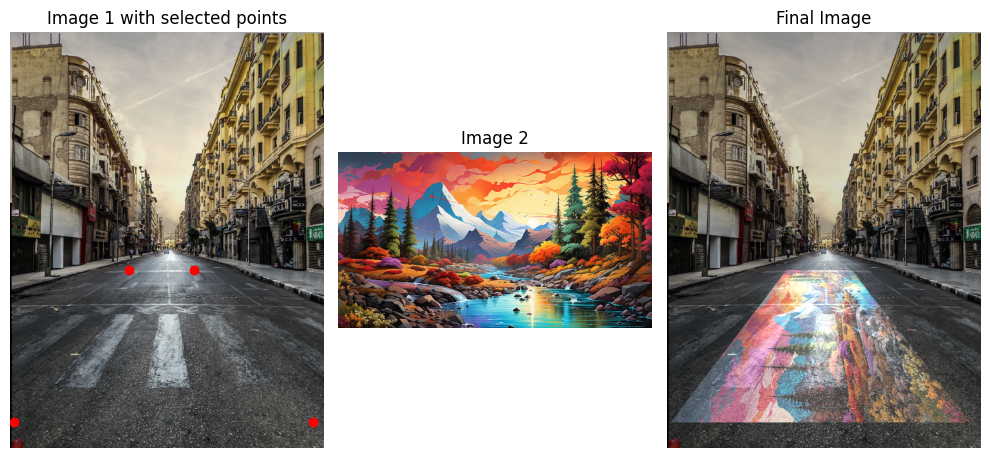

In [175]:
dst = superimpose(img3, logo, dst_points, 0.7, 0.9)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img3)
plt.scatter(dst_points[:, 0], dst_points[:, 1], color = 'red')
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(logo)
plt.title("Image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dst)
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()

In [176]:
img3 = cv.imread("/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/Blank book.jpg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

logo = cv.imread("/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/cover.jpeg")
logo = cv.cvtColor(logo, cv.COLOR_BGR2RGB)

dst_points = [(300, 230), (208, 35), (47, 78), (114, 285)]
dst_points = np.array([np.array(p) for p in dst_points])

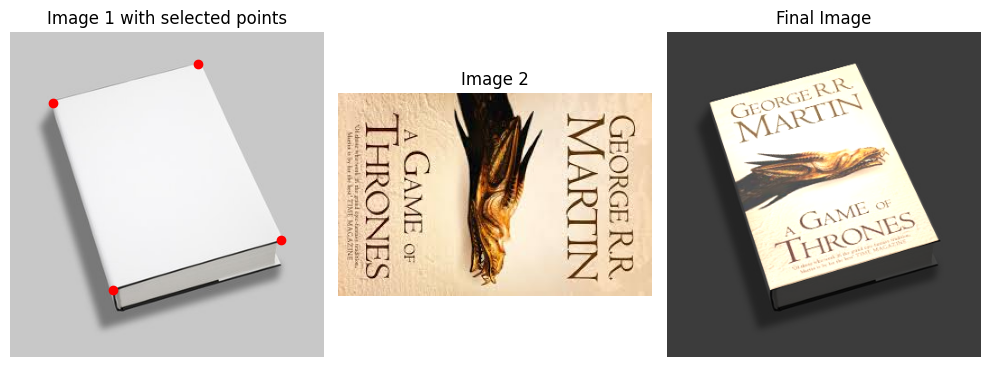

In [177]:
dst = superimpose(img3, logo, dst_points, 0.9, 0.3)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img3)
plt.scatter(dst_points[:, 0], dst_points[:, 1], color = 'red')
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(logo)
plt.title("Image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dst)
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()

# Question 04

In [178]:
def SIFT_features(img1, img5, plot=False):
    # Convert both images to grayscale
    img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_RGB2GRAY)

    # Create SIFT detector and compute keypoints and descriptors
    sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1)
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

    # Match descriptors using BFMatcher with KNN
    matches = cv.BFMatcher().knnMatch(descriptors1, descriptors5, k=2)

    # Filter good matches based on the ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # If plot is True, visualize keypoints and matched features
    if plot:
        plt.figure(figsize=(10, 5))
        # Image 1 keypoints
        plt.subplot(1, 2, 1)
        plt.imshow(cv.drawKeypoints(img1_gray, keypoints1, None))
        plt.title("Image 1 SIFT features")
        plt.axis('off')

        # Image 5 keypoints
        plt.subplot(1, 2, 2)
        plt.imshow(cv.drawKeypoints(img5_gray, keypoints5, None))
        plt.title("Image 5 SIFT features")
        plt.axis('off')

        plt.tight_layout()

        # Display matched features between the two images
        plt.figure(figsize=(12, 6))
        matched_img = cv.drawMatches(img1_gray, keypoints1, img5_gray, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(matched_img)
        plt.title("Matched features between image 1 and 5")
        plt.axis('off')

    return good_matches, keypoints1, keypoints5


In [179]:
def get_inliers(src_full, dst_full, tform, thres):
    # Apply transformation to source points and calculate error
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis=1))

    # Return indices where error is below the threshold
    return np.where(errors < thres)[0]


def find_best_homography(good_matches, keypoints1, keypoints5):
    # Prepare arrays of matching points
    src_full = np.array([np.array(keypoints1[match.queryIdx].pt) for match in good_matches])
    dst_full = np.array([np.array(keypoints5[match.trainIdx].pt) for match in good_matches])

    # RANSAC setup parameters
    num_points = 4
    thres = 1
    iters = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    # Perform RANSAC
    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace=False)

        src_points = np.array([np.array(keypoints1[match.queryIdx].pt) for match in chosen_matches])
        dst_points = np.array([np.array(keypoints5[match.trainIdx].pt) for match in chosen_matches])

        # Estimate projective transformation
        tform = transform.estimate_transform('projective', src_points, dst_points)

        # Calculate inliers using the get_inliers function
        inliers = get_inliers(src_full, dst_full, tform, thres)

        # Update best homography if more inliers are found
        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers


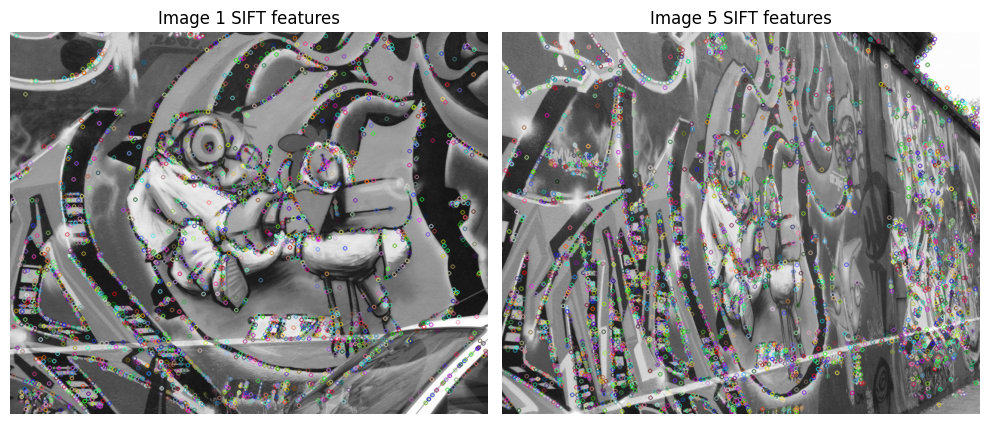

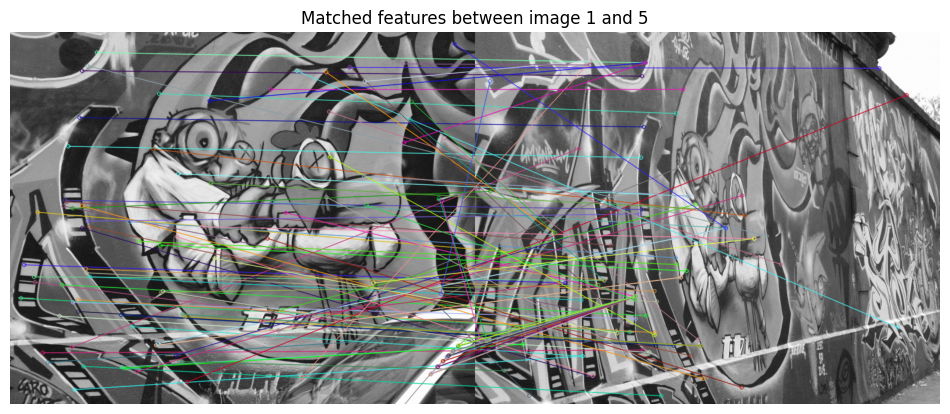

In [180]:
img1 = cv.imread("/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/graf/graf/img1.ppm")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img5 = cv.imread("/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/graf/graf/img5.ppm")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

features = SIFT_features(img1, img5, plot = True)

Best no. of inliers = 734
Best no. of inliers = 544
Best no. of inliers = 695
Best no. of inliers = 493


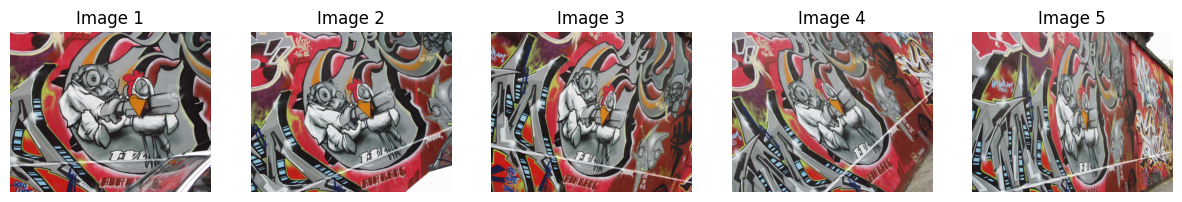

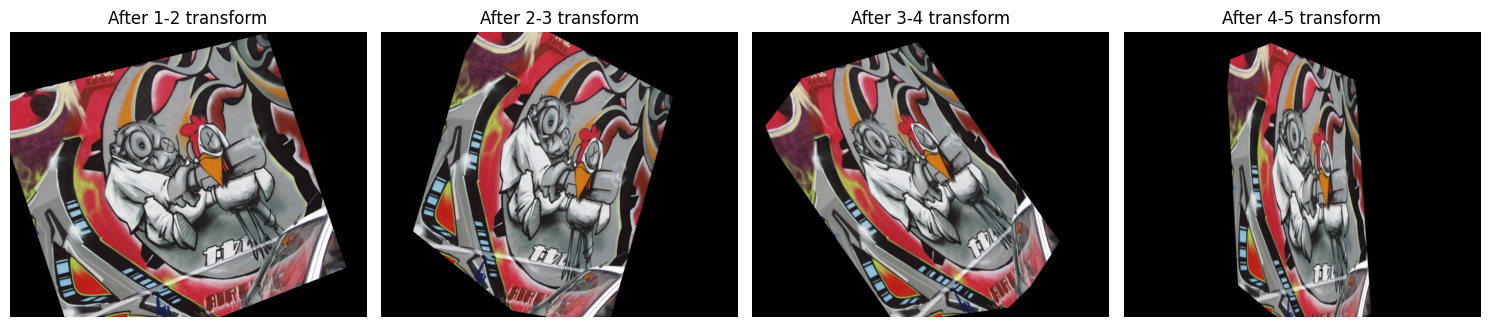

In [182]:
np.random.seed(62)
pad = 100

# Read and display images
images = []
plt.figure(figsize=(15, 10))
for i in range(1, 6):
    img = cv.imread(f"/content/EN3160---Image-Processing-and-Machine-Vision/Assignment 2/Files/graf/graf/img{i}.ppm")
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert to RGB
    images.append(img_rgb)
    plt.subplot(1, 5, i)
    plt.imshow(img_rgb)
    plt.title(f"Image {i}")
    plt.axis('off')

# Initialize projective transformation matrix
final_transform = transform.ProjectiveTransform(np.identity(3))

# Apply transformations between consecutive images and display results
plt.figure(figsize=(15, 10))
final_transformed_image = images[0]

for i in range(1, 5):
    # Select consecutive image pairs
    img1, img2 = images[i-1], images[i]

    # Get SIFT features and match points
    good_matches, keypoints1, keypoints5 = SIFT_features(img1, img2)

    # Find best homography using RANSAC
    tform, _ = find_best_homography(good_matches, keypoints1, keypoints5)

    # Apply the transformation to the current image
    final_transformed_image = transform.warp(final_transformed_image, tform.inverse)

    # Update the cumulative transformation matrix
    final_transform = final_transform + tform

    # Plot the transformed image after each step
    plt.subplot(1, 4, i)
    plt.imshow(final_transformed_image)
    plt.title(f"After {i}-{i+1} transform")
    plt.axis('off')

plt.tight_layout()

# Apply the final transformation to the first image and display it
final_transformed_image = transform.warp(images[0], final_transform.inverse)


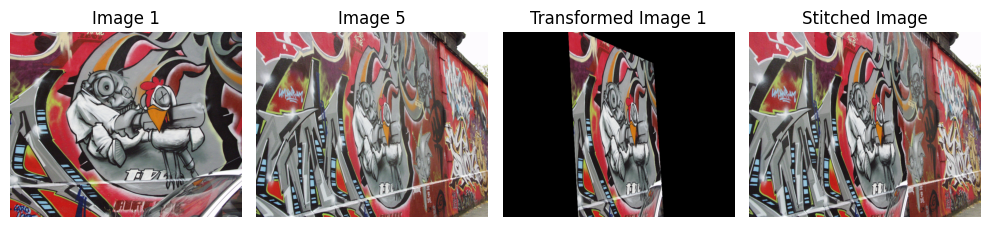

In [183]:
# Warp the first image using the final cumulative transformation
final_transformed_image = transform.warp(images[0], final_transform.inverse)

# Scale the warped image back to uint8 format
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)

# Create a mask where the transformed image has zero values (black pixels)
mask = (final_transformed_image == 0)

# Use the mask to fill missing areas in the transformed image with data from the 5th image
stitched_image = mask * images[4] + final_transformed_image

# Plot the original, transformed, and stitched images
plt.figure(figsize=(10, 10))

# Display original first image
plt.subplot(1, 4, 1)
plt.imshow(images[0])
plt.title("Image 1")
plt.axis('off')

# Display original fifth image
plt.subplot(1, 4, 2)
plt.imshow(images[4])
plt.title("Image 5")
plt.axis('off')

# Display the transformed first image
plt.subplot(1, 4, 3)
plt.imshow(final_transformed_image)
plt.title("Transformed Image 1")
plt.axis('off')

# Display the stitched image (combination of the transformed image and the fifth image)
plt.subplot(1, 4, 4)
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')

# Adjust the layout of the plots
plt.tight_layout()


In [184]:
# Define the actual transformation matrix
actual_transformation = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                                   [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
                                   [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])

# Display the computed and actual homographies
print("Computed Homography:")
print(final_transform.params)
print()

print("Actual Homography:")
print(actual_transformation)
print()

# Calculate and print the sum of squared errors between the two matrices
squared_errors_sum = np.sum(np.square(actual_transformation - final_transform.params))
print("Sum of Squared Errors:", squared_errors_sum)


Computed Homography:
[[ 6.11404405e-01  5.03189278e-02  2.21391689e+02]
 [ 2.11980188e-01  1.14096497e+00 -2.14952560e+01]
 [ 4.74861259e-04 -5.18621428e-05  9.90604813e-01]]

Actual Homography:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Sum of Squared Errors: 17.281051922979206
